In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


Reading the dataset for training. 

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Reshaping the columns of the dataframe to form the images. 

In [3]:
Y_train = train["label"]
X_train = train.drop(["label"],axis=1)
X_train = X_train.values.astype('float32')
X_train = X_train.reshape(X_train.shape[0],28,28,1)
print("Size of dataset: ",X_train.shape)

Size of dataset:  (42000, 28, 28, 1)


Visualizing and verifying one of the images in the dataset.

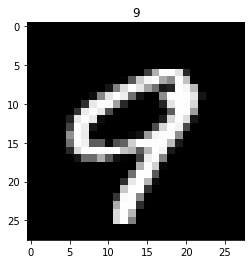

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[100], cmap=plt.get_cmap('gray'))
plt.title(Y_train[100]);

I have used three methods for data augmentation:
1. Image Binarization
2. Image Rotation
3. Image translation

In [5]:
#Converting the images to black and white
import cv2

X_train_bw = np.zeros((len(X_train),28,28))
for i in range(len(X_train)):
    (thresh, X_train_bw[i,:,:]) = cv2.threshold(X_train[i], 127, 255, cv2.THRESH_BINARY)

X_train_bw = X_train_bw.reshape(len(X_train_bw),28,28,1)

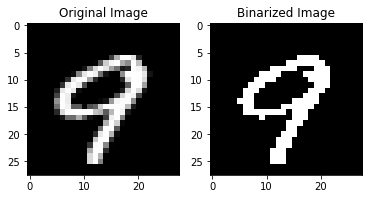

In [6]:
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(X_train[100], cmap=plt.get_cmap('gray'))

plt.subplot(1,2,2)
plt.title('Binarized Image')
plt.imshow(X_train_bw[100], cmap=plt.get_cmap('gray'))

In [7]:
#Rotating the images clockwise and anticlockwise by 20 degrees. 

pos_matrix = cv2.getRotationMatrix2D((14, 14), 20, 1.0)
neg_matrix = cv2.getRotationMatrix2D((14, 14), -20, 1.0)

X_train_rot_pos = np.zeros((len(X_train),28,28))
for i in range(len(X_train)):
    X_train_rot_pos[i,:,:] = cv2.warpAffine(X_train[i], pos_matrix, (28, 28))
X_train_rot_pos = X_train_rot_pos.reshape(len(X_train_rot_pos),28,28,1)

X_train_rot_neg = np.zeros((len(X_train),28,28))
for i in range(len(X_train)):
    X_train_rot_neg[i,:,:] = cv2.warpAffine(X_train[i], neg_matrix, (28, 28))
X_train_rot_neg = X_train_rot_neg.reshape(len(X_train_rot_neg),28,28,1)


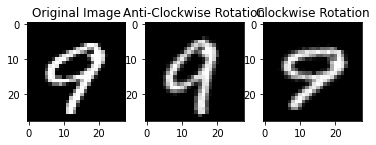

In [8]:
#Verifying
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(X_train[100],cmap=plt.get_cmap('gray'))

plt.subplot(1,3,2)
plt.title('Anti-Clockwise Rotation')
plt.imshow(X_train_rot_pos[100], cmap=plt.get_cmap('gray'))

plt.subplot(1,3,3)
plt.title('Clockwise Rotation')
plt.imshow(X_train_rot_neg[100], cmap=plt.get_cmap('gray'))

In [9]:
#Translation of images by 5 units in all four directions.

pos_trans_x = np.float32([[1, 0, 5], [0, 1, 0]]) 
neg_trans_x = np.float32([[1, 0, -5], [0, 1, 0]]) 
pos_trans_y = np.float32([[1, 0, 0], [0, 1, 5]]) 
neg_trans_y = np.float32([[1, 0, 0], [0, 1, -5]]) 

X_train_pos_x = np.zeros((len(X_train),28,28))
X_train_pos_y = np.zeros((len(X_train),28,28))
X_train_neg_x = np.zeros((len(X_train),28,28))
X_train_neg_y = np.zeros((len(X_train),28,28))
for i in range(len(X_train)):
    X_train_pos_x[i,:,:] = cv2.warpAffine(X_train[i], pos_trans_x, (28, 28))
    X_train_pos_y[i,:,:] = cv2.warpAffine(X_train[i], pos_trans_y, (28, 28))
    X_train_neg_x[i,:,:] = cv2.warpAffine(X_train[i], neg_trans_x, (28, 28))
    X_train_neg_y[i,:,:] = cv2.warpAffine(X_train[i], neg_trans_y, (28, 28))
    
X_train_pos_x = X_train_pos_x.reshape(len(X_train_pos_x),28,28,1)
X_train_pos_y = X_train_pos_y.reshape(len(X_train_pos_y),28,28,1)
X_train_neg_x = X_train_neg_x.reshape(len(X_train_neg_x),28,28,1)
X_train_neg_y = X_train_neg_y.reshape(len(X_train_neg_y),28,28,1)

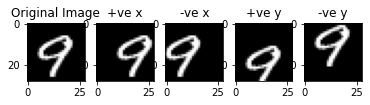

In [10]:
#Verifying
plt.subplot(1,5,1)
plt.imshow(X_train[100],cmap=plt.get_cmap('gray'))
plt.title('Original Image')

plt.subplot(1,5,2)
plt.title('+ve x')
plt.imshow(X_train_pos_x[100], cmap=plt.get_cmap('gray'))

plt.subplot(1,5,3)
plt.title('-ve x')
plt.imshow(X_train_neg_x[100], cmap=plt.get_cmap('gray'))

plt.subplot(1,5,4)
plt.title('+ve y')
plt.imshow(X_train_pos_y[100], cmap=plt.get_cmap('gray'))

plt.subplot(1,5,5)
plt.title('-ve y')
plt.imshow(X_train_neg_y[100], cmap=plt.get_cmap('gray'))

In [11]:
#Adding all the generated data

X_train = np.concatenate((X_train,X_train_bw,X_train_rot_pos,X_train_rot_neg,
                          X_train_pos_x,X_train_neg_x,X_train_pos_y,X_train_neg_y),axis=0)
Y_train = pd.concat([Y_train,Y_train,Y_train,Y_train,Y_train,Y_train,Y_train,Y_train],axis=0)
Y_train = Y_train.values
print("Number of images: ",len(X_train))
print("Number of labels: ",len(Y_train))

Number of images:  336000
Number of labels:  336000


In [12]:
#Normalizing the dataset

max_px = X_train.max()
min_px = X_train.min()
print("Maximum pixel value: ",max_px)
print("Minimum pixel value: ",min_px)

X_train = (X_train - min_px)/(max_px - min_px)

Maximum pixel value:  255.0
Minimum pixel value:  0.0


In [13]:
#One-Hot encoding the labels

from keras.utils import to_categorical

Y_train_encoded = to_categorical(Y_train)
print("Shape of labels: ",Y_train_encoded.shape)
#Verifying
print(Y_train[10])
print(Y_train_encoded[10])

Shape of labels:  (336000, 10)
8
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Here I have used NAdam as the optimizer and kullback_leibler_divergence as the loss function. 
The CNN model is as follows:
Conv2D*2 --> MaxPooling2D --> Dropout --> Conv2D*2 --> MaxPooling2D --> Flatten --> Dense --> Dropout --> Dense (output)

In [14]:
#CNN classifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,Input

input_shape = (28,28,1)
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

Training the model...

In [15]:
model.compile(optimizer='Nadam', loss='kullback_leibler_divergence', metrics=['accuracy'])
model.fit(X_train,Y_train_encoded, batch_size=128, epochs=10,validation_split=0.1)

Epoch 1/10
2363/2363 [==============================] - 1009s 427ms/step - loss: 0.3392 - accuracy: 0.8911 - val_loss: 0.0928 - val_accuracy: 0.9712
Epoch 2/10
2363/2363 [==============================] - 1011s 428ms/step - loss: 0.0490 - accuracy: 0.9852 - val_loss: 0.0654 - val_accuracy: 0.9800
Epoch 3/10
2363/2363 [==============================] - 1012s 428ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0585 - val_accuracy: 0.9823
Epoch 4/10
2363/2363 [==============================] - 1015s 430ms/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.0671 - val_accuracy: 0.9814
Epoch 5/10
2363/2363 [==============================] - 1024s 433ms/step - loss: 0.0227 - accuracy: 0.9932 - val_loss: 0.0379 - val_accuracy: 0.9885
Epoch 6/10
2363/2363 [==============================] - 1018s 431ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0404 - val_accuracy: 0.9877
Epoch 7/10
2363/2363 [==============================] - 1020s 432ms/step - loss: 0.0168 - accuracy: 0.9948

In [16]:
#Analyzing the wrong predictions in the train dataset

Y_train_predict = model.predict(X_train)
predicted_train_label = []
for y in Y_train_predict:
    predicted_train_label.append(np.argmax(y))
    
wrong_prediction = []
for l in range(len(predicted_train_label)):
    if(predicted_train_label[l] != Y_train[l]):
        wrong_prediction.append(l)
print(len(wrong_prediction))

696


Reading the test dataset

In [17]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


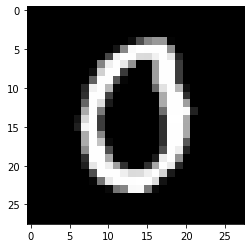

In [18]:
X_test = test.values.astype('float32')
X_test = X_test.reshape(X_test.shape[0],28,28,1)
plt.imshow(X_test[100], cmap=plt.get_cmap('gray'))

In [19]:
#Normalizing the test dataset

max_px = X_test.max()
min_px = X_test.min()
print("Maximum pixel value: ",max_px)
print("Minimum pixel value: ",min_px)

X_test = (X_test - min_px)/(max_px - min_px)

Maximum pixel value:  255.0
Minimum pixel value:  0.0


In [20]:
#Predicting the test labels using the trained model

Y_predict = model.predict(X_test)

In [21]:
#Finding the predicted label using the predicted probabilities

predicted_label = []
for y in Y_predict:
    predicted_label.append(np.argmax(y))

In [22]:
#Writing the result in the output file

submission_df = pd.DataFrame({'ImageId' : list(range(1,test.shape[0]+1)),'Label' : predicted_label})
submission = submission_df.to_csv('submission.csv',index=False)